In [1]:
!pip install -q yfinance
!pip install -q hmmlearn
!pip install -q xgboost
!pip install -q backtrader

You should consider upgrading via the 'C:\Users\Lidor\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\Lidor\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\Lidor\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\Lidor\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
import datetime
from backtrader.feeds import PandasData
import backtrader as bt
import backtrader.analyzers as btanalyzers
from sklearn.preprocessing import LabelEncoder
# Warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = yf.download('^RUA', start = '2002-12-31', end = '2023-07-01', progress = False)
df.index = pd.to_datetime(df.index)
df['Return'] = df['Close'].pct_change()

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2002-12-31,489.010010,491.059998,483.880005,489.489990,489.489990,0,NaN
2003-01-02,489.489990,505.179993,489.489990,505.179993,505.179993,0,0.032054
2003-01-03,505.179993,506.230011,502.100006,504.769989,504.769989,0,-0.000812
2003-01-06,504.769989,517.530029,504.769989,516.039978,516.039978,0,0.022327
2003-01-07,516.039978,516.650024,510.769989,512.450012,512.450012,0,-0.006957


In [5]:
df = df.loc['2003-01-02':]

In [6]:
df

,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2003-01-02,489.489990,505.179993,489.489990,505.179993,505.179993,0,0.032054
2003-01-03,505.179993,506.230011,502.100006,504.769989,504.769989,0,-0.000812
2003-01-06,504.769989,517.530029,504.769989,516.039978,516.039978,0,0.022327
2003-01-07,516.039978,516.650024,510.769989,512.450012,512.450012,0,-0.006957
2003-01-08,512.450012,512.450012,504.529999,505.309998,505.309998,0,-0.013933
...,...,...,...,...,...,...,...
2023-06-26,2490.560059,2500.739990,2481.739990,2482.060059,2482.060059,0,-0.003581
2023-06-27,2486.439941,2515.919922,2486.300049,2512.429932,2512.429932,0,0.012236
2023-06-28,2509.030029,2520.459961,2503.169922,2513.479980,2513.479980,0,0.000418


Text(0, 0.5, 'Close Price')

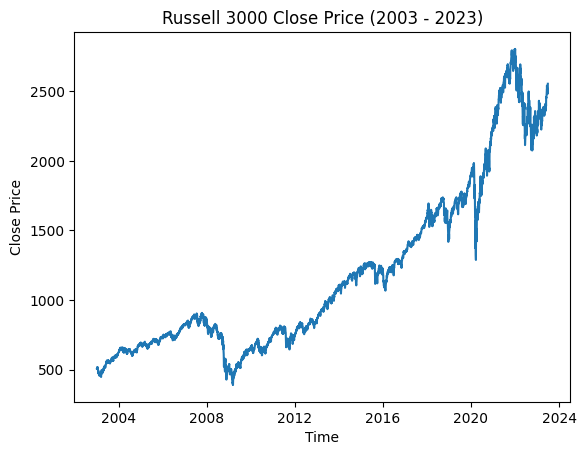

In [7]:
# Plot Russell 3000 close price from 2003 to 2023
plt.plot(df['Close'])
plt.title('Russell 3000 Close Price (2003 - 2023)')
plt.xlabel('Time')
plt.ylabel('Close Price')

Text(0, 0.5, 'Return')

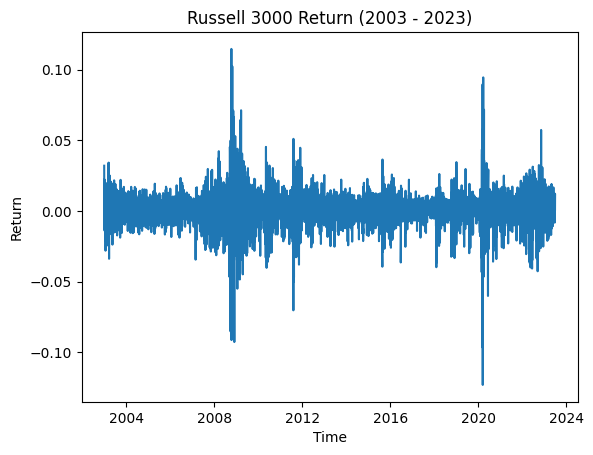

In [8]:
# Plot Russell 3000 return from 2003 to 2023
plt.plot(df['Return'])
plt.title('Russell 3000 Return (2003 - 2023)')
plt.xlabel('Time')
plt.ylabel('Return')

In [9]:
df_new = df.reset_index(inplace = True, drop = False)
df_new = pd.DataFrame(df['Return'])

In [10]:
stock = list(df_new.itertuples(index = False, name = None))

In [11]:
return_val = np.array([i[0] for i in stock])
X = np.column_stack([return_val])

In [12]:
# Assume the distribution of emission probabilities is Gaussian, and use HMM to decode states
model = GaussianHMM(n_components = 3) #TODO Check which number is best
model.fit(X)
hidden_states = model.predict(X)
states = pd.DataFrame(hidden_states)
states.columns = ['state']

In [13]:
states

,state
0,0
1,0
2,0
3,0
4,0
...,...
5125,1
5126,1
5127,1
5128,1


In [14]:
# Combine decoded states with original dataframe
result = pd.concat([df, states], axis = 1)
result.set_index(['Date'], inplace = True)
result.head()

,Open,High,Low,Close,Adj Close,Volume,Return,state
Date,,,,,,,,
2003-01-02,489.489990,505.179993,489.489990,505.179993,505.179993,0,0.032054,0
2003-01-03,505.179993,506.230011,502.100006,504.769989,504.769989,0,-0.000812,0
2003-01-06,504.769989,517.530029,504.769989,516.039978,516.039978,0,0.022327,0
2003-01-07,516.039978,516.650024,510.769989,512.450012,512.450012,0,-0.006957,0
2003-01-08,512.450012,512.450012,504.529999,505.309998,505.309998,0,-0.013933,0


Text(0, 0.5, 'Close Price')

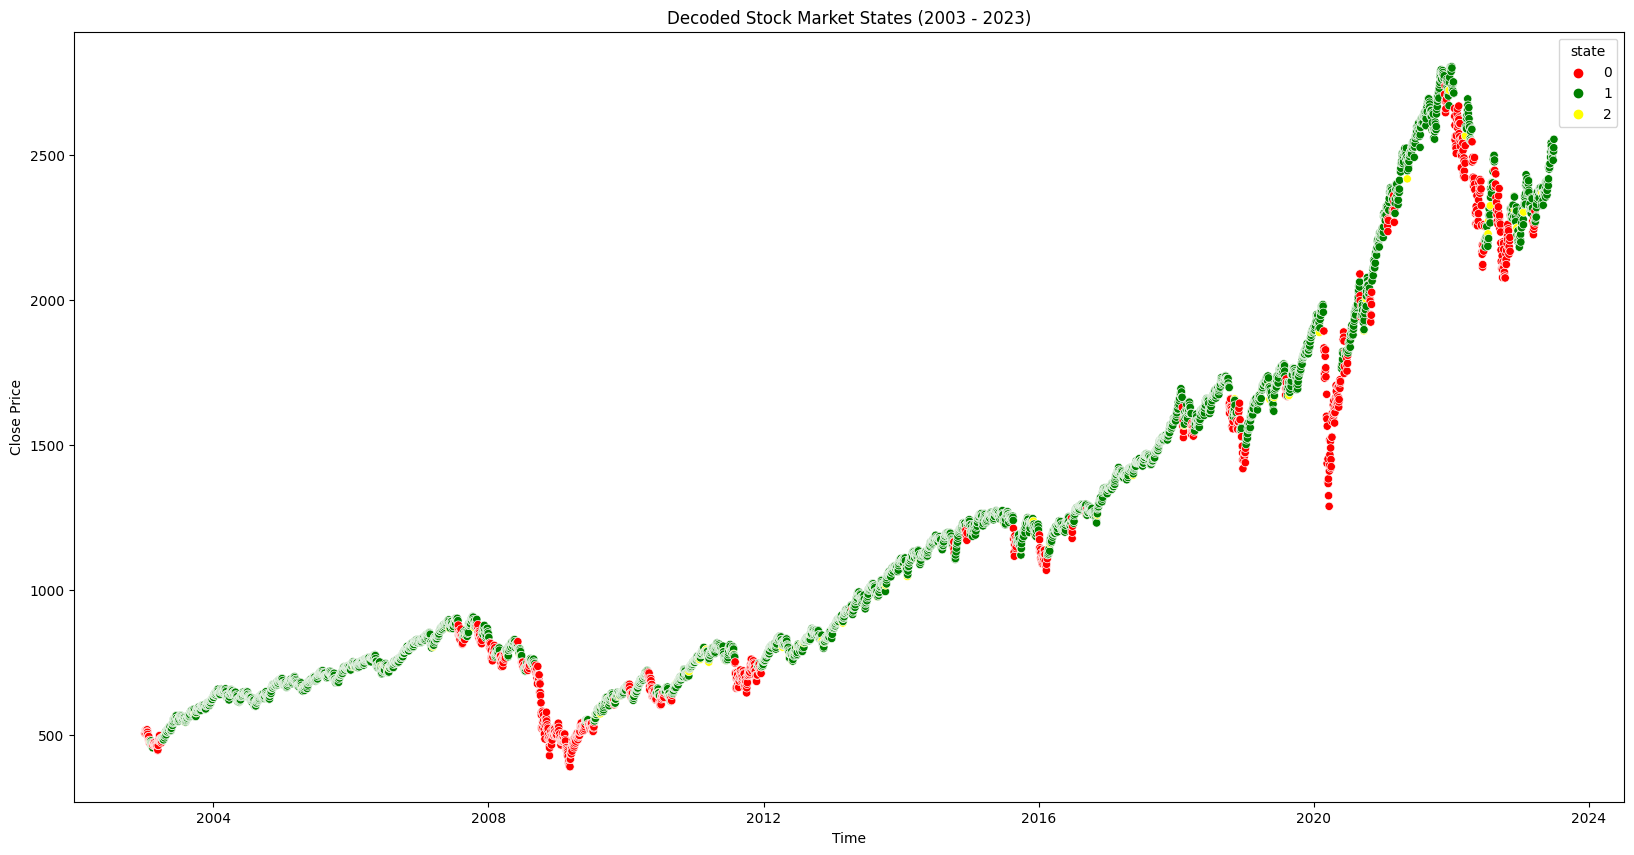

In [15]:
# Plot decoded states from 2003 to 2023
colors = {0: 'red', 1: 'green', 2: 'yellow'}
plt.figure(figsize = (20, 10))
sns.scatterplot(x = result.index, y = result['Close'], palette=colors, hue = result['state'])
plt.title('Decoded Stock Market States (2003 - 2023)')
plt.xlabel('Time')
plt.ylabel('Close Price')

In [16]:
# Map the states to -1,0,1 based on above plot
# result['state'] = result['state'].map({0: 1, 1: -1,2: 0})
# result

Text(0, 0.5, 'Close Price')

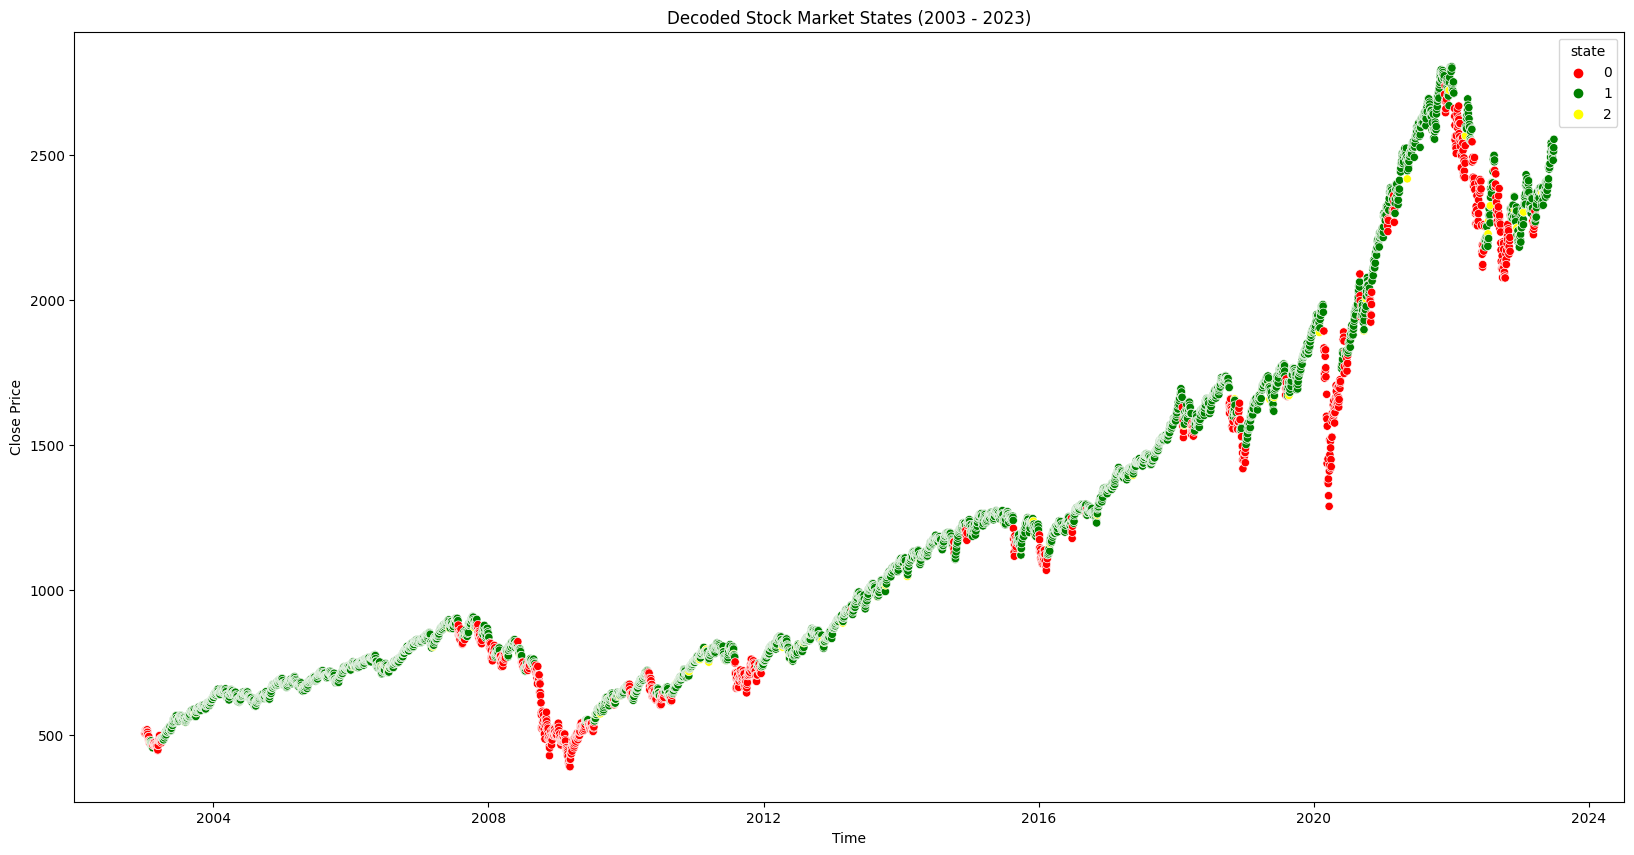

In [18]:
# Plot decoded states from 2003 to 2023 after mapping
# colors = {1: 'red', -1: 'green', 0: 'yellow'}
colors = {0: 'red', 1: 'green', 2: 'yellow'}
plt.figure(figsize = (20, 10))
sns.scatterplot(x = result.index, y = result['Close'], palette = colors, hue = result['state'])
plt.title('Decoded Stock Market States (2003 - 2023)')
plt.xlabel('Time')
plt.ylabel('Close Price')

In [19]:
# Parameters needed for RandomizedSearch
xg_grid = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'max_depth': [3, 4, 5]
}

In [22]:
# Set X to be return and y to be state, the training period is 2003-2019 and testing period is 2020-2023 
# Fit XGBoost model
X_train, y_train = result.loc['2003-01-02':'2020-01-01',:]['Return'], result.loc['2003-01-02':'2020-01-01']['state']
X_test, y_test = result.loc['2020-01-01':'2023-07-01',:]['Return'], result.loc['2020-01-01':'2023-07-01']['state']

In [23]:
xg = XGBClassifier()
xg_random = RandomizedSearchCV(estimator = xg, param_distributions = xg_grid, n_iter = 100, verbose = 2, random_state = 42, n_jobs = -1) #TODO parameters to try for best
# le = LabelEncoder()
# y_train = le.fit_transform(y_train) # b/c it's must be from 0 start
xg_random.fit(X_train, y_train)
params = xg_random.best_params_

Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [24]:
model = XGBClassifier(**params).fit(X_train, y_train)

In [25]:
y_pred = model.predict(X_test)

In [26]:
result.loc['2020-01-01':'2023-07-01',[ 'predict']] = y_pred.reshape(-1, 1)

In [27]:
result['state'] = result['state'].map({1: 0, -1: 1, 0: 2})
# Print the predicted result from 2020 to 2023
result = result.loc['2020-01-01':'2023-07-01']
result

,Open,High,Low,Close,Adj Close,Volume,Return,state,predict
Date,,,,,,,,,
2020-01-02,1898.469971,1906.650024,1893.540039,1906.500000,1906.500000,0,0.007531,0.0,1.0
2020-01-03,1898.089966,1900.459961,1889.489990,1894.530029,1894.530029,0,-0.006279,0.0,1.0
2020-01-06,1885.390015,1900.989990,1883.300049,1900.900024,1900.900024,0,0.003362,0.0,1.0
2020-01-07,1899.050049,1900.219971,1893.150024,1896.010010,1896.010010,0,-0.002572,0.0,1.0
2020-01-08,1896.880005,1912.890015,1895.989990,1905.020020,1905.020020,0,0.004752,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2023-06-26,2490.560059,2500.739990,2481.739990,2482.060059,2482.060059,0,-0.003581,0.0,1.0
2023-06-27,2486.439941,2515.919922,2486.300049,2512.429932,2512.429932,0,0.012236,0.0,1.0
2023-06-28,2509.030029,2520.459961,2503.169922,2513.479980,2513.479980,0,0.000418,0.0,1.0


In [28]:
def function(a, b):
    if a == b:
        return 1
    else:
        return 0

In [29]:
# Dataframe the checking results
result['bool'] = result.apply(lambda x : function(x['state'], x['predict']), axis = 1)
result

,Open,High,Low,Close,Adj Close,Volume,Return,state,predict,bool
Date,,,,,,,,,,
2020-01-02,1898.469971,1906.650024,1893.540039,1906.500000,1906.500000,0,0.007531,0.0,1.0,0
2020-01-03,1898.089966,1900.459961,1889.489990,1894.530029,1894.530029,0,-0.006279,0.0,1.0,0
2020-01-06,1885.390015,1900.989990,1883.300049,1900.900024,1900.900024,0,0.003362,0.0,1.0,0
2020-01-07,1899.050049,1900.219971,1893.150024,1896.010010,1896.010010,0,-0.002572,0.0,1.0,0
2020-01-08,1896.880005,1912.890015,1895.989990,1905.020020,1905.020020,0,0.004752,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...
2023-06-26,2490.560059,2500.739990,2481.739990,2482.060059,2482.060059,0,-0.003581,0.0,1.0,0
2023-06-27,2486.439941,2515.919922,2486.300049,2512.429932,2512.429932,0,0.012236,0.0,1.0,0
2023-06-28,2509.030029,2520.459961,2503.169922,2513.479980,2513.479980,0,0.000418,0.0,1.0,0


In [30]:
f1 = f1_score(y_pred, y_test, average = 'weighted')
f1

0.8361959252535255

In [31]:
# Print best params of XGBoost model
params

{'min_child_weight': 5, 'max_depth': 3, 'gamma': 2}

In [32]:
# Set strategy
class PandasData(PandasData):
    '''
        The ``dataname`` parameter inherited from ``feed.DataBase`` is the pandasDataFrame
    '''
    lines = ('state',)
    params = (
        ('datetime', 0),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', None),
        ('openinterest', None),
        ('state', 8),
    )
    datafields = PandasData.datafields + (['state'])

In [33]:
# Strategy based on market states
class MarketStatus(bt.Strategy): 
    def log(self, txt, dt = None):
        dt = dt or self.datas[0].datetime.date(0)

    def __init__(self):
        self.dataclose = self.datas[0].close
        # Order variable will contain ongoing order details/status
        self.order = None
        # Instantiate market status
        self.state = self.datas[0].state

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # An active Buy/Sell order has been submitted/accepted - Nothing to do
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
            elif order.issell():
                self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        # Reset orders
        self.order = None

    def next(self):
        # Check for open orders
        if self.order:
            return
        if self.state[0] == 1:
            if not self.position:
                self.log(f'BUY CREATE {self.dataclose[0]:2f} {self.state[0]:2f}')
                self.order = self.buy()
            elif self.position.size < 0: # already have a sell order
                self.order = self.close()
                self.log(f'CLOSE CREATE {self.dataclose[0]:2f}')
                self.log(f'BUY CREATE {self.dataclose[0]:2f} {self.state[0]:2f}')
                self.order = self.buy()
            elif self.position.size > 0: # already have a buy order
                # Check the period of current states
                if len(self) == (self.bar_executed + 5):
                    self.log(f'BUY CREATE {self.dataclose[0]:2f} {self.state[0]:2f}')
                    self.order = self.buy()
                    self.log('Chase')
                elif len(self) >= (self.bar_executed + 15):
                    self.order = self.close()
                    self.log(f'CLOSE CREATE {self.dataclose[0]:2f}')
                else:
                    pass
            else:
                pass
        elif self.state[0] == -1:
            if not self.position:           
                self.log(f'SELL CREATE {self.dataclose[0]:2f} {self.state[0]:2f}')
                self.order = self.sell()
            elif self.position.size > 0: # already have a buy order             
                self.order = self.close()
                self.log(f'CLOSE CREATE {self.dataclose[0]:2f}')
                self.log(f'SELL CREATE {self.dataclose[0]:2f} {self.state[0]:2f}')
                self.order = self.sell()
            elif self.position.size < 0: # already have a sell order
                if len(self) == (self.bar_executed + 5):
                    self.log(f'SELL CREATE {self.dataclose[0]:2f} {self.state[0]:2f}')
                    self.order = self.sell()
                elif len(self) >= (self.bar_executed + 15):
                    self.order = self.close()
                    self.log(f'CLOSE CREATE {self.dataclose[0]:2f}')
                else:
                    pass
            else:
                pass
        else:
            if not self.position:
                pass
            else:
                self.log(f'Hold {self.dataclose[0]:2f} {self.state[0]:2f}')

In [34]:
# Benchmark strategy - BuyAndHold
class BuyAndHold(bt.Strategy):
    def log(self, txt, dt = None):
        dt = dt or self.datas[0].datetime.date(0)
    
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        
    def notify_order(self,order):
        if order.status in [order.Submitted, order.Accepted]:
			# An active Buy/Sell order has been submitted/accepted - Nothing to do
            return
        # Check if an order has been completed
		# Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
            elif order.issell():
                self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
    def next(self):
        # Check for open orders
        if self.order:
            return
        self.log(f'BUY CREATE {self.dataclose[0]:2f}')
        self.order = self.buy()

In [35]:
def run_cerebro(df, strategy):
    df = df.reset_index()
    state_column = df.shape[1] - 2
    # Instantiate Cerebro engine
    cerebro = bt.Cerebro()
    data = PandasData(
        dataname = df,
        fromdate = datetime.datetime(2020, 1, 2),
        todate = datetime.datetime(2023, 7, 1),
        datetime = 0,
        open = 1,
        high = 2,
        low = 3,
        close = 4,
        state = state_column,
    )
    # Add data to Cerebro
    cerebro.adddata(data)
    # Add strategy to Cerebro
    cerebro.addstrategy(strategy)
    # Default position size
    cerebro.addsizer(bt.sizers.SizerFix, stake = 1)
    # Add analytics to Cerebro
    cerebro.addanalyzer(btanalyzers.SharpeRatio, _name = 'SharpeRatio')
    cerebro.addanalyzer(btanalyzers.AnnualReturn, _name = 'AnnualReturn')
    cerebro.addanalyzer(btanalyzers.DrawDown, _name = 'DrawDown')
    cerebro.addanalyzer(btanalyzers.TimeDrawDown, _name = 'TimeDrawDown')
    cerebro.addanalyzer(btanalyzers.PositionsValue, _name = 'PositionsValue')
    cerebro.addanalyzer(btanalyzers.LogReturnsRolling, _name = 'LogReturnsRolling')
    cerebro.addanalyzer(btanalyzers.PeriodStats, _name = 'PeriodStats')
    cerebro.addanalyzer(btanalyzers.Returns, _name = 'Returns')
    cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name = 'TradeAnalyzer')
    cerebro.addanalyzer(btanalyzers.Transactions, _name = 'Transactions')
    # Run Cerebro engine
    start_portfolio_value = cerebro.broker.getvalue()
    # cerebro.run()
    thestrats = cerebro.run()
    thestrat = thestrats[0]
    end_portfolio_value = cerebro.broker.getvalue()
    pnl = end_portfolio_value - start_portfolio_value
    print(f'Starting Portfolio Value: {start_portfolio_value:2f}')
    print(f'Final Portfolio Value: {end_portfolio_value:2f}')
    print(f'PnL: {pnl:.2f}\n')
    sharpe = thestrat.analyzers.SharpeRatio.get_analysis()['sharperatio']
    return pnl, sharpe

In [40]:
# PnL and Sharpe Ratio using MarketStatus starategy
pnl, sharpe = run_cerebro(result, MarketStatus)

Starting Portfolio Value: 10000.000000
Final Portfolio Value: 10271.159668
PnL: 271.16



In [41]:
pnl, sharpe

(271.15966796875, 0.030860966348799156)

In [42]:
# PnL and Sharpe Ratio using BuyAndHold starategy
pnl, sharpe = run_cerebro(result, BuyAndHold)

Starting Portfolio Value: 10000.000000
Final Portfolio Value: 10656.400024
PnL: 656.40



In [43]:
pnl, sharpe

(656.4000244140625, 0.16851292836072726)